#  I. Import Needed Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import os
print(os.listdir())

import warnings
warnings.filterwarnings('ignore')


# keras 2.4.3
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

#sklearn 0.23.2
from sklearn.model_selection import train_test_split

['.config', 'heart_disease_uci.csv', 'sample_data']


# II. Pre-Process Data

## A. import data 

In [2]:
dataset = pd.read_csv('./heart_disease_uci.csv')

Sample of data view

In [3]:
dataset.head(5)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


we have 16 columns (14 features) and 920 records

In [4]:
dataset.shape

(920, 16)

## B. Analysing Dataset

dataset information

In [5]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


## C. Remove Spaces (renaming)

In some of the features, there is space will will create problem later on. So we rename those attributes to handle problems in the future.

In [6]:
dataset["restecg"].replace({"lv hypertrophy": "lv_hypertrophy","st-t abnormality": "stt_abnormality" }, inplace=True)
dataset['thal'].replace({'fixed defect':'fixed_defect' , 'reversable defect': 'reversable_defect' }, inplace =True)
dataset['cp'].replace({'typical angina':'typical_angina', 'atypical angina': 'atypical_angina' }, inplace =True)

Sample view

In [7]:
dataset.head(5)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical_angina,145.0,233.0,True,lv_hypertrophy,150.0,False,2.3,downsloping,0.0,fixed_defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv_hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv_hypertrophy,129.0,True,2.6,flat,2.0,reversable_defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical_angina,130.0,204.0,False,lv_hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### Replace null values in thal with unknown category


In [8]:
#Distribution of Target Feature


dataset.describe()


,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


## C. Numberizing features :
- num --rename--> target

- target: target> 0 -> 1 | target=0 -> 0
- sex: male ---------> 1 | female ---> 0
- fbs: True ----------> 1 | false -----> 0
- exang: True-------> 1 | false -----> 0
- cp: typical_angina ---> 0, ---> atypical_angina 1, asymptomatic ---> 2, non-anginal ---> 3

In [9]:
data_tmp = dataset[['age','sex','cp', 'trestbps', 'chol', 'fbs',  'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']].copy()
data_tmp['target'] = ((dataset['num'] > 0)*1).copy()
data_tmp['sex'] = (dataset['sex'] == 'Male')*1
data_tmp['fbs'] = (dataset['fbs'])*1
data_tmp['exang'] = (dataset['exang'])*1
data_tmp['slope'].replace({'downsloping':'0', 'flat': '1', 'upsloping' : '2' , 'unknown' : '3'}, inplace =True)
data_tmp['cp'].replace({'typical_angina':'0', 'atypical_angina': '1', 'asymptomatic' : '2', 'non-anginal' : '3' }, inplace =True)



## D. Drop null values

In [10]:
data_tmp.isnull().sum() 

age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

Show null data

### 1. Drop 'ca'  and 'thal' values

In [11]:
data_tmp2 = data_tmp[['age','sex','cp', 'trestbps', 'chol', 'fbs',  'thalch', 'exang', 'oldpeak', 'slope','target' ]]

### 2. Replace null values in slope with unknown 


In [12]:
data_tmp2['slope']= data_tmp2['slope'].fillna("unknown")

replace 'unknown ' with 3

In [13]:
data_tmp2['slope'].replace({'downsloping':'0', 'flat': '1', 'upsloping' : '2' , 'unknown' : '3'}, inplace =True)

### 3. replace null in oldpeak feature by median


In [14]:
data_tmp2['oldpeak']=data_tmp2['oldpeak'].replace(np.NaN,data_tmp2['oldpeak'].median())


### 4. replace null in exang feature by most occured

In [15]:
data_tmp2['exang']= data_tmp2['exang'].fillna("1")

In [16]:

data_tmp2.isnull().sum()

age          0
sex          0
cp           0
trestbps    59
chol        30
fbs         90
thalch      55
exang        0
oldpeak      0
slope        0
target       0
dtype: int64

### 5. replace null in thalch feature by median


In [17]:
data_tmp2['thalch']=data_tmp2['thalch'].replace(np.NaN,data_tmp2['thalch'].median())


### 4. replace null in fbs feature by most occured

In [18]:
data_tmp2['fbs']= data_tmp2['fbs'].fillna("1")


### 6. replace null in chol feature by median

In [19]:
data_tmp2['chol']=data_tmp2['chol'].replace(np.NaN,data_tmp2['chol'].median())


### 7. replace null in trestbps feature by median

In [20]:
data_tmp2['trestbps']=data_tmp2['trestbps'].replace(np.NaN,data_tmp2['trestbps'].median())


### 8. replace null in cp feature by unknown attribute

In [21]:
data_tmp2['cp']= data_tmp2['cp'].fillna("unknown")

In [22]:
data_tmp2['cp'].replace({'typical_angina':'0', 'atypical_angina': '1', 'asymptomatic' : '2', 'non-anginal' : '3' , 'unknown' : '4'}, inplace =True)


### 9. replace null in sex feature by male (0)

In [23]:
data_tmp2['sex']= data_tmp2['sex'].fillna("0")

### 10. replace null in age feature by mean

In [24]:
data_tmp2['age']=data_tmp2['age'].replace(np.NaN,data_tmp2['age'].mean())

In [25]:
data_tmp2.shape


(920, 11)

In [26]:
data_tmp2.isnull().sum() 

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
thalch      0
exang       0
oldpeak     0
slope       0
target      0
dtype: int64

In [27]:
data_tmp2.shape

(920, 11)

##### Now data has 0 null value

### Renaming features

In [28]:
data_tmp2.columns = ['age', 'gender', 'chest_pain_type', 'resting_blood_pressure', 
              'cholesterol', 'fasting_blood_sugar',
              'max_heart_rate_achieved', 'exercise_induced_angina', 
              'st_depression', 'slope_st_depression', 'target']
data_tmp2.head(5)


,age,gender,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,slope_st_depression,target
0,63,1,0,145.0,233.0,1,150.0,0,2.3,0,0
1,67,1,2,160.0,286.0,0,108.0,1,1.5,1,1
2,67,1,2,120.0,229.0,0,129.0,1,2.6,1,1
3,37,1,3,130.0,250.0,0,187.0,0,3.5,0,0
4,41,0,1,130.0,204.0,0,172.0,0,1.4,2,0


In [29]:
data_tmp2.shape


(920, 11)

# II. Select features

## View correlated features with target 

In [30]:
correlated_f= data_tmp2.corr()["target"].abs().sort_values(ascending=False)
pd.DataFrame(correlated_f)

,target
target,1.000000
max_heart_rate_achieved,0.381864
st_depression,0.366138
gender,0.307284
age,0.282700
cholesterol,0.228976
resting_blood_pressure,0.101273


#### decision not made yet

## 3.1 Splitting data

In [31]:
from sklearn.model_selection import train_test_split
data=data_tmp2
y = data['target']
X = data.drop('target', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

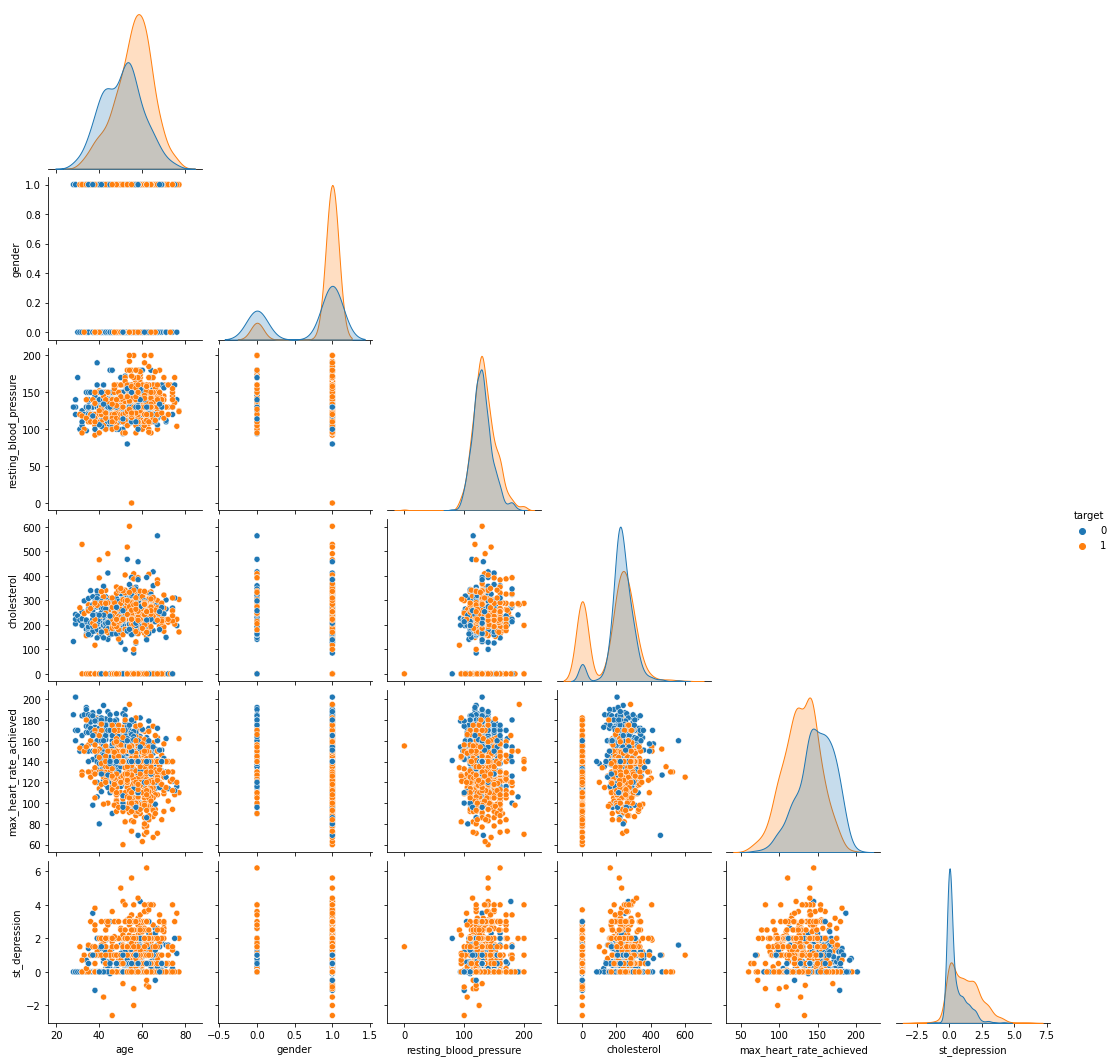

In [32]:
sns.pairplot(data,hue='target',corner=True)


In [33]:
X_train.shape


(736, 10)

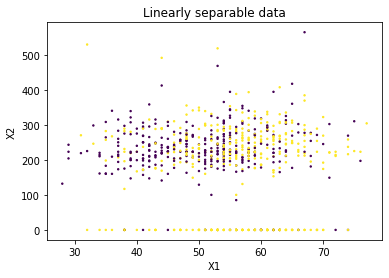

In [34]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
# Generate scatter plot for training data 
plt.scatter(X_train['age'], X_train['cholesterol'], s=2, c=y_train )
plt.title('Linearly separable data')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [35]:
X_test.shape


(184, 10)

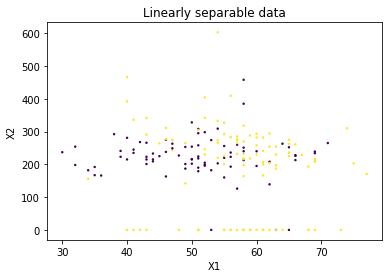

In [36]:
# Generate scatter plot for training data 
plt.scatter(X_test['age'], X_test['cholesterol'], s=2, c=y_test )
plt.title('Linearly separable data')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## SVM

In [37]:
from sklearn import svm

sv = svm.SVC(kernel='linear')

sv.fit(X_train, y_train)

Y_pred_svm = sv.predict(X_test)

In [38]:
#libraries of performance measurements
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score  
from sklearn.metrics import precision_score



In [39]:
score_svm = round(accuracy_score(Y_pred_svm,y_test)*100,2)
pscore_svm = round(precision_score(y_test,Y_pred_svm)*100,2)

print("The accuracy score achieved using Linear SVM is: "+str(score_svm)+" %")
print("The precision score achieved using Linear SVM is: "+str(score_svm)+" %")

The accuracy score achieved using Linear SVM is: 75.0 %
The precision score achieved using Linear SVM is: 75.0 %


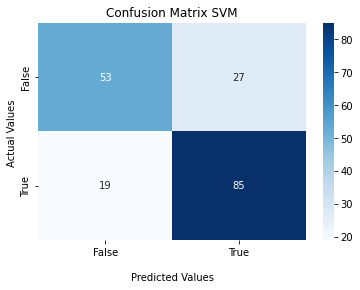

In [40]:
 #  simple cm
cm_matrixSVM = confusion_matrix(y_test, Y_pred_svm)
cf_matrix= cm_matrixSVM
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix SVM');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()


## Dicision Trees

In [41]:
from sklearn.tree import DecisionTreeClassifier

max_accuracy = 0


for x in range(2000):
    dt = DecisionTreeClassifier(random_state=x)
    dt.fit(X_train,y_train)
    Y_pred_dt = dt.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_dt,y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        
#print(max_accuracy)
print("random state number is" , best_x)


dt = DecisionTreeClassifier(random_state=best_x)
dt.fit(X_train,y_train)
Y_pred_dt = dt.predict(X_test)

random state number is 33


In [42]:
score_dt = round(accuracy_score(Y_pred_dt,y_test)*100,2)
pscore_dt = round(precision_score(y_test,Y_pred_dt)*100,2)

print("The accuracy score achieved using DT is: "+str(score_dt)+" %")
print("The precision score achieved using DT is: "+str(pscore_dt)+" %")

The accuracy score achieved using DT is: 75.0 %
The precision score achieved using DT is: 76.85 %


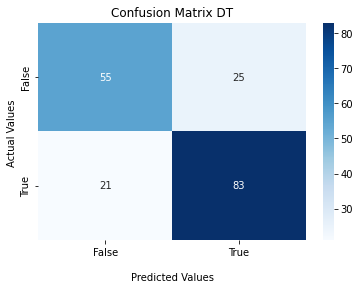

In [43]:
#Generate the confusion matrix
cf_matrixDT = confusion_matrix(y_test, Y_pred_dt)

cf_matrix=cf_matrixDT
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix DT');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Random Forests

In [44]:
from sklearn.ensemble import RandomForestClassifier

max_accuracy = 0

for x in range(500):
    rf = RandomForestClassifier(random_state=x)
    rf.fit(X_train,y_train)
    Y_pred_rf = rf.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_rf,y_test)*100,3)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        
#print(max_accuracy)
print("random state number is" , best_x)


random state number is 284


In [45]:
rf = RandomForestClassifier(random_state=best_x)
rf.fit(X_train,y_train)
Y_pred_rf = rf.predict(X_test)

In [46]:
score_rf = round(accuracy_score(Y_pred_rf,y_test)*100,2)

pscore_rf = round(precision_score(y_test,Y_pred_dt)*100,2)

print("The accuracy score achieved using rf is: "+str(score_rf)+" %")
print("The precision score achieved using rf is: "+str(pscore_rf)+" %")

The accuracy score achieved using rf is: 83.7 %
The precision score achieved using rf is: 76.85 %


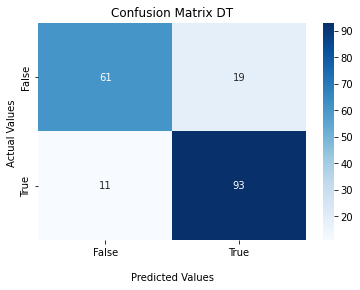

In [47]:
#Generate the confusion matrix
cf_matrixRF = confusion_matrix(y_test, Y_pred_rf)

cf_matrix=cf_matrixRF
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix DT');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Test Data

choose a record from test dataset

In [48]:
#X_test.loc[1, : ]
newItem_not_sick = pd.DataFrame(X_test.iloc[44, : ]).transpose()

newItem_not_sick

,age,gender,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,slope_st_depression
415,50,1,1,140.0,216.0,0,170.0,0,0.0,3


In [49]:
Y_pred_rf0 = rf.predict(newItem_not_sick)
print(Y_pred_rf0)

[0]


In [50]:
newItem_sick = pd.DataFrame(X_test.iloc[82, : ]).transpose()

newItem_sick

,age,gender,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,slope_st_depression
751,77,1,2,124.0,171.0,0,110.0,1,2.0,2


In [51]:
Y_pred_rf1 = rf.predict(newItem_sick)
print(Y_pred_rf1)

[1]


In [52]:
print("nourAmmar 2022")

nourAmmar 2022
